# **Sentiment Analysis on Twitter (Sentiment140)**

## **Notebook Objectives**

The goal of this notebook is to build and compare two deep learning approaches for binary sentiment classification (positive vs negative) on the Sentiment140 Twitter dataset:

- A BiLSTM model with GloVe embeddings (classical NLP pipeline)

- A Transformer-based model (DistilBERT) fine-tuned using PyTorch and GPU acceleration

This notebook focuses on:

- Text preprocessing strategies

- Efficient training on large-scale datasets

- Performance comparison between LSTM and Transformer models

## **1- Environment Setup & Dependencies**

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
#API to fetch dataset from Kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.54GB/s]


In [3]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


## **2- Imports & Libraries**

In [4]:
# Data handling
import pandas as pd
import numpy as np
import re

# NLP (classical)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Deep Learning (TensorFlow – LSTM)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# PyTorch + Transformers (BERT)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# Evaluation & visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## **3- Dataset Loading & Exploration**

In [5]:
columns = ['target', 'id', 'date', 'query', 'user', 'text']
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", names =columns, encoding='ISO-8859-1')

In [ ]:
df1 = df[['target', 'text']]
df1['target'] = df['target'].map({0: 0, 4: 1})
df1.head()

/tmp/ipython-input-2857880388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['target'] = df['target'].map({0: 0, 4: 1})


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


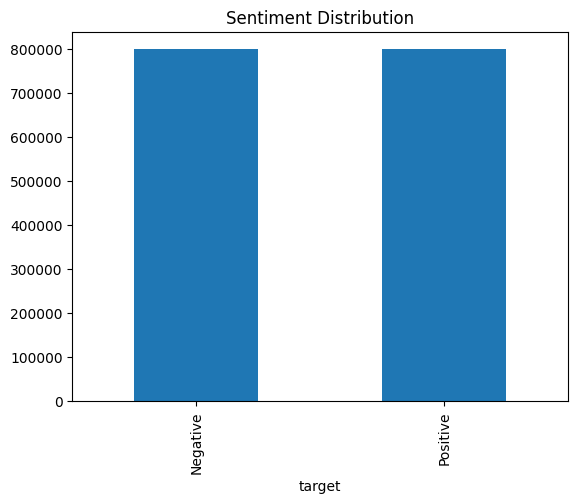

In [ ]:
df1['target'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xticks([0,1], ['Negative', 'Positive'])
plt.show()

# **PART I — BiLSTM with GloVe Embeddings (TensorFlow)**

## **1- Text Preprocessing (Classical NLP)**

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

text_cleaning_re = r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z\s]"

def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

df1['text'] = df1['text'].apply(preprocess)


/tmp/ipython-input-2532195581.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text'] = df1['text'].apply(preprocess)


## **2- Train / Validation / Test Split**

In [ ]:
# Split data : 80% train, 10% validation, 10% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df1['text'], df1['target'], test_size=0.2, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print(f"Train: {len(train_texts)}, Validation: {len(val_texts)}, Test: {len(test_texts)}")

Train: 1280000, Validation: 160000, Test: 160000


## **3- Tokenization & Padding**

In [ ]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_texts)

word_index = tokenizer.word_index
vocab_size = min(MAX_NB_WORDS, len(word_index)) + 1
print("Vocabulary Size :", vocab_size)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences   = tokenizer.texts_to_sequences(val_texts)
test_sequences  = tokenizer.texts_to_sequences(test_texts)

# Padding
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val   = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test  = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

y_train = np.array(train_labels)
y_val   = np.array(val_labels)
y_test  = np.array(test_labels)


Vocabulary Size : 100001


## **4- GloVe Embeddings Loading**

GloVe is a pre-trained set of word vectors that represent each word as numbers.
We use it here to convert the words in tweets into meaningful numerical vectors, so that the BiLSTM can understand word meanings and better predict sentiment.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

EMBEDDING_DIM = 100
embeddings_index = {}

with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")


--2025-12-20 16:47:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-20 16:47:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-20 16:47:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


This step builds a custom embedding matrix that maps each word in our vocabulary to its pretrained GloVe vector (if available), enabling smart initialization of the model’s embedding layer — while respecting the MAX_NB_WORDS limit and leaving unknown words as zero vectors.

In [ ]:
found = 0
not_found = 0
not_found_words = []

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    if word in embeddings_index:
        found += 1
    else:
        not_found += 1
        not_found_words.append(word)

print(f"Words found in GloVe: {found}")
print(f"Words NOT found in GloVe: {not_found}")
print(f"Coverage: {found / (found + not_found):.2%}")
print(f"Exemple of not found words: {not_found_words[:20]}")

Words found in GloVe: 56117
Words NOT found in GloVe: 43882
Coverage: 56.12%
Exemple of not found words: ['hahaha', 'lmao', 'bday', 'idk', 'hahah', 'hahahaha', 'tweeps', 'thanx', 'cooky', 'gunna', 'hehehe', 'ughh', 'soooooo', 'sux', 'booo', 'ahaha', 'retweet', 'youu', 'tmrw', 'ughhh']


The out-of-vocabulary words mainly consist of slang, abbreviations, elongated expressions, and social media-specific terms, which are not included in the GloVe vocabulary.

**Coverage: 56.12% → GOOD**

## **5- BiLSTM Model Architecture**

A BiLSTM extends LSTM by processing sequences in both forward and backward directions, allowing the model to capture both past and future context, which leads to better performance in sentiment analysis tasks.

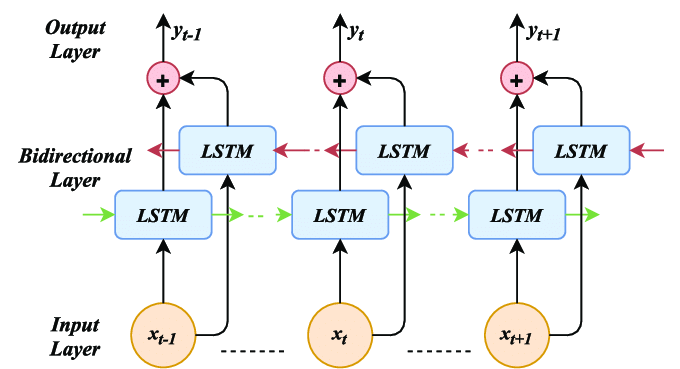

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=EMBEDDING_DIM, # 100
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(5e-4), metrics=['accuracy'])


## **6- Training & Evaluation (LSTM)**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)


Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 156s 15ms/step - accuracy: 0.7269 - loss: 0.5377 - val_accuracy: 0.7639 - val_loss: 0.4850
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 146s 15ms/step - accuracy: 0.7667 - loss: 0.4838 - val_accuracy: 0.7737 - val_loss: 0.4690
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 161s 16ms/step - accuracy: 0.7752 - loss: 0.4692 - val_accuracy: 0.7771 - val_loss: 0.4626
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - accuracy: 0.7809 - loss: 0.4605 - val_accuracy: 0.7802 - val_loss: 0.4603
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 171s 17ms/step - accuracy: 0.7855 - loss: 0.4529 - val_accuracy: 0.7818 - val_loss: 0.4568
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 175s 17ms/step - accuracy: 0.7892 - loss: 0.4468 - val_accuracy: 0.7832 - val_loss: 0.4554
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 176s 18ms/step - accuracy: 0.7920 - loss: 0.4423 - val_accuracy: 0.7847 - val_loss: 0.4534
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 153s 15ms/s

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 50, 100)         │    10,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (128, 50, 128)         │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (128, 64)              │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 64)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 256)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (128, 256)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 1)               │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,427,881 (39.78 MB)

 Trainable params: 142,593 (557.00 KB)

 Non-trainable params: 10,000,100 (38.15 MB)

 Optimizer params: 285,188 (1.09 MB)

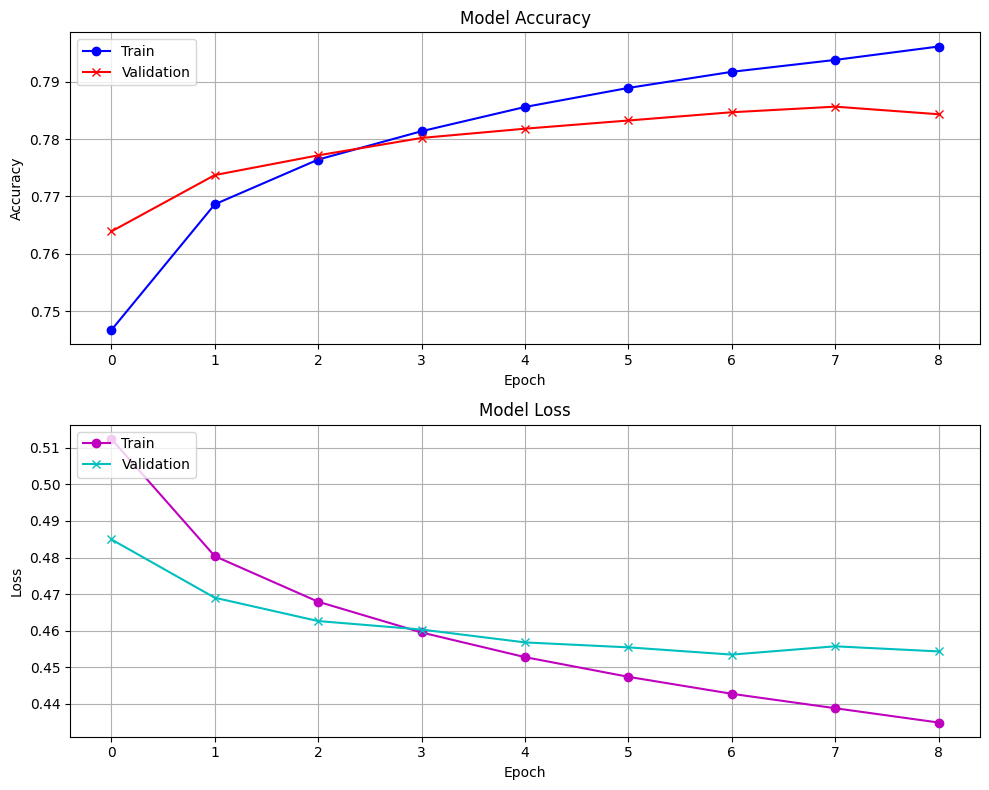

In [ ]:
# Create a figure with two subplots (Accuracy and Loss)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

ax1.plot(history.history['accuracy'], color='b', marker='o')
ax1.plot(history.history['val_accuracy'], color='r', marker='x')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

ax2.plot(history.history['loss'], color='m', marker='o')
ax2.plot(history.history['val_loss'], color='c', marker='x')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

The training curves show a steady improvement in both training and validation accuracy with a small generalization gap, indicating good model convergence and limited overfitting. Early stopping successfully prevents unnecessary training once validation performance plateaus.

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78     79807
    Positive       0.78      0.80      0.79     80193

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



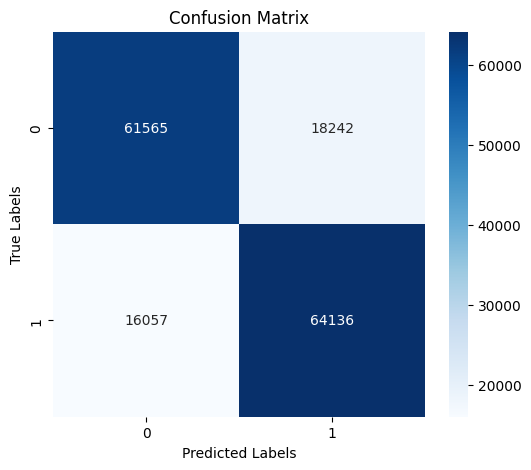

In [ ]:
# Predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


The model achieves an overall accuracy of 78% on a balanced test set. Precision, recall, and F1-scores are consistent across both classes, indicating stable and unbiased performance. The model shows slightly better recall for the positive class, while maintaining comparable precision for both classes.

# **PART II — DistilBERT Fine-Tuning (PyTorch)**

## **1- Device Configuration**

In [19]:
# Checks whether a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **2- Minimal BERT Preprocessing (No stemming / stopwords)**

In [20]:
df_bert = df[['target', 'text']].copy()
df_bert['target'] = df_bert['target'].map({0:0, 4:1})

def preprocess_bert(text):
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", str(text))
    return text.strip()

df_bert['text'] = df_bert['text'].apply(preprocess_bert)

## **3- Dataset Subsampling (Efficiency)**

In [21]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_bert['text'], df_bert['target'], test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [22]:
train_texts_small = train_texts[:200_000]
train_labels_small = train_labels[:200_000]

val_texts_small = val_texts[:20_000]
val_labels_small = val_labels[:20_000]

test_texts_small = test_texts[:20_000]
test_labels_small = test_labels[:20_000]

The dataset is split into training, validation, and test sets using an 80/10/10 ratio, with reduced subsets selected to enable efficient DistilBERT fine-tuning on limited GPU resources.

## **4- Tokenization with HuggingFace**

In [23]:
from tqdm import tqdm # A library to show a progress bar for loops

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Loads the tokenizer from Hugging Face
MAX_LEN = 50

def batch_tokenize_pt(texts, tokenizer, batch_size=10000, max_length=MAX_LEN):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        enc = tokenizer(
            list(batch),
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt' # returns PyTorch tensors
        )

        input_ids.append(enc['input_ids'])
        attention_masks.append(enc['attention_mask'])

    return {
        'input_ids': torch.cat(input_ids, dim=0),
        'attention_mask': torch.cat(attention_masks, dim=0)
    }

train_encodings = batch_tokenize_pt(train_texts_small, tokenizer)
val_encodings   = batch_tokenize_pt(val_texts_small, tokenizer)
test_encodings  = batch_tokenize_pt(test_texts_small, tokenizer)

100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


We cannot feed 1.6 million tweets into BERT at once — it would crash the RAM or GPU memory.

So, we split the data into smaller batches (batch_size) to process them gradually.

tqdm is used just to display a progress bar while tokenizing.

# **5- PyTorch Dataset & DataLoaders**

In [24]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_numpy() if isinstance(labels, pd.Series) else np.array(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TweetDataset(train_encodings, train_labels_small)
val_dataset   = TweetDataset(val_encodings, val_labels_small)
test_dataset  = TweetDataset(test_encodings, test_labels_small)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## **6- Model, Optimizer & Scheduler**

The model consists of two main parts:

- DistilBERT encoder (backbone): responsible for extracting contextual text representations.

- Classification head: a lightweight neural network that maps these representations to sentiment labels.

To reduce computational cost and limit overfitting, only the classification head is trained, while the DistilBERT backbone is frozen.

In [25]:
# AutoModelForSequenceClassification is a Hugging Face class that loads a pre-trained BERT model

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, # distilBERT
    num_labels=2,
    dropout=0.3
)
model.to(device)

# Freeze DistilBERT backbone (train only the classification head)
for param in model.distilbert.parameters():
    param.requires_grad = False


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=0.01
)

EPOCHS = 10
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

AdamW optimizer for BERT parameters with small learning rate

Linear scheduler with warmup: gradually increase LR for first 10% steps, then decrease linearly

## **7- Mixed Precision Training Loop**

In [27]:
#Mixed Precision Training

scaler = torch.cuda.amp.GradScaler()

def train_epoch(model, loader):

    model.train() # training mode
    total_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        optimizer.zero_grad()
        # Move inputs and labels to the GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass with mixed precision (autocast)
        # Some operations use float16 to save memory and speed up computation
        with torch.amp.autocast("cuda"):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()

        # Compute accuracy for this batch
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def eval_epoch(model, loader):

    model.eval() # evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            # Move inputs and labels to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass (no gradient computation)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

/tmp/ipython-input-2797386217.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [28]:
# Training Loop with Early Stopping

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
patience = 3
counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss:   {val_loss:.4f}")
    print(f"Val acc:    {val_acc:.4f}")
    print("-"*30)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # saves only the weights of the best-performing model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping !")
            break

Epoch 1/10
Train loss: 0.5421
Val loss:   0.4927
Val acc:    0.7605
------------------------------
Epoch 2/10
Train loss: 0.5187
Val loss:   0.4686
Val acc:    0.7718
------------------------------
Epoch 3/10
Train loss: 0.5104
Val loss:   0.4680
Val acc:    0.7735
------------------------------
Epoch 4/10
Train loss: 0.5053
Val loss:   0.4563
Val acc:    0.7827
------------------------------
Epoch 5/10
Train loss: 0.5003
Val loss:   0.4544
Val acc:    0.7845
------------------------------
Epoch 6/10
Train loss: 0.4969
Val loss:   0.4475
Val acc:    0.7872
------------------------------
Epoch 7/10
Train loss: 0.4944
Val loss:   0.4459
Val acc:    0.7900
------------------------------
Epoch 8/10
Train loss: 0.4912
Val loss:   0.4426
Val acc:    0.7903
------------------------------
Epoch 9/10
Train loss: 0.4881
Val loss:   0.4415
Val acc:    0.7914
------------------------------
Epoch 10/10
Train loss: 0.4868
Val loss:   0.4406
Val acc:    0.7921
------------------------------


## **9- Final Evaluation on Test Set**

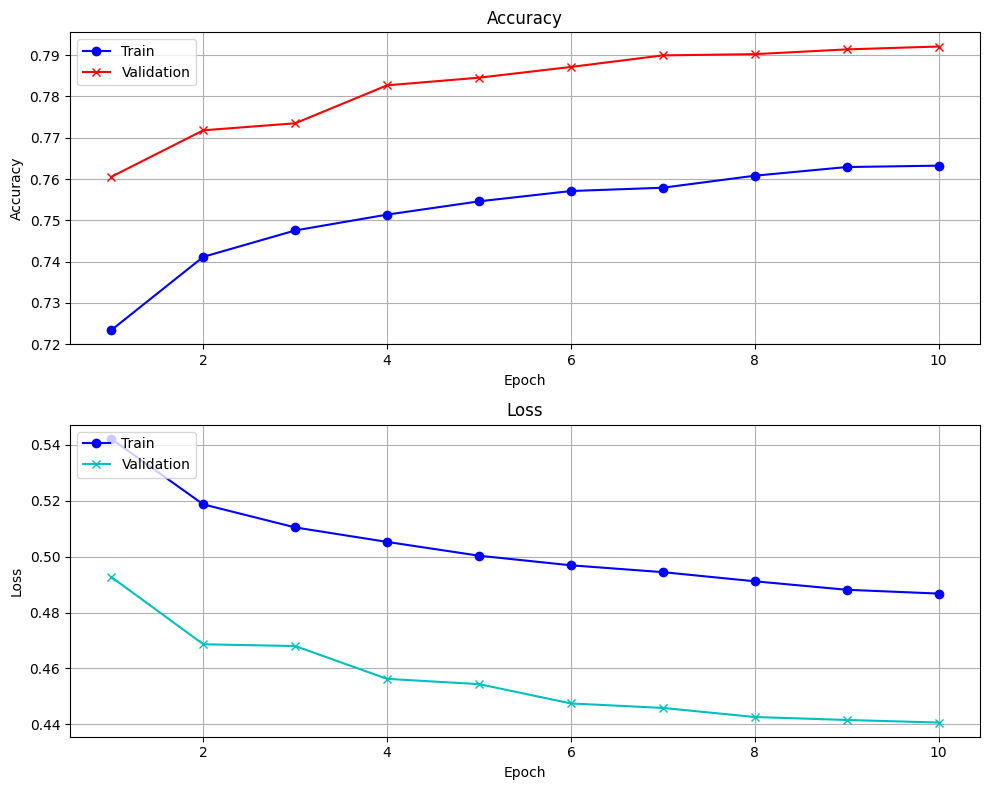

In [29]:
# Plot Accuracy and Loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Accuracy
ax1.plot(range(1, len(train_accuracies)+1), train_accuracies, color='b', marker='o')
ax1.plot(range(1, len(val_accuracies)+1), val_accuracies, color='r', marker='x')
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# Loss
ax2.plot(range(1, len(train_losses)+1), train_losses, color='b', marker='o')
ax2.plot(range(1, len(val_losses)+1), val_losses, color='c', marker='x')
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

Good training behavior:

- Both train and validation accuracy increase steadily → model is learning effectively.
- Validation accuracy reaches ~**79%** → solid performance for a frozen encoder setup.
- Train and val curves stay close, with no divergence → no overfitting.

Loss decreases smoothly for both train and validation → consistent improvement, stable optimization.

              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      9943
    Positive       0.80      0.78      0.79     10057

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



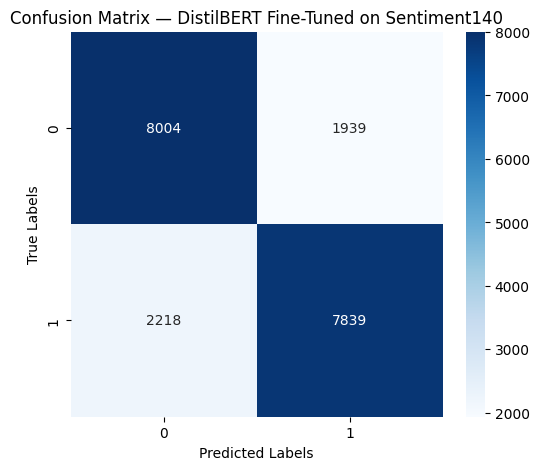

In [30]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — DistilBERT Fine-Tuned on Sentiment140")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [31]:
# Save model to a .pkl file
torch.save(model.state_dict(), "best_model.pkl")
print("Model saved as best_model.pkl")

Model saved as best_model.pkl


# **Conclusion**

In this notebook, we explored two approaches for Twitter sentiment analysis (Sentiment140):

**BiLSTM with GloVe** – a classical NLP method capturing sequential context, offering decent performance but limited by vocabulary coverage and understanding of complex language.

**DistilBERT (Transformer)** – a modern pre-trained model, fine-tuned on the classification head, providing better understanding of context and subtle language nuances.

***Key points:***

Text preprocessing (cleaning, lemmatization, stopword removal) is essential for both models.

Transformers generally outperform LSTMs, especially on large datasets.

***Final remark:***

Pre-trained models like DistilBERT provide significant performance gains and flexibility while requiring less training time when only the classification head is fine-tuned.